In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
import os
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm 
import seaborn as sns
from PIL import Image
from numpy import asarray

np.set_printoptions(precision=5)#show 5 number after decimal point 

In [2]:
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [3]:
url = r"C:\\Users\\noa12\\OneDrive\\מסמכים\\GitHub\\Dogs_Vs_Cats_Project\\train\\"

In [4]:
def create_data():
    data = list()
    label = 0 #cat = 1 , dog = 0
    for img in tqdm(os.listdir(url)):
        if img.startswith('cat'): label = 1 
        else :label = 0 
        im = asarray(Image.open(url+img).resize((55,55)).convert('L')) #resize and changing colors
        data.append([im,label])
    np.save('data.npy', data)
    return data

In [5]:
data = create_data()

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [03:35<00:00, 115.83it/s]


In [5]:
# load the data:
data = np.load('data.npy',allow_pickle=True)

In [6]:
X = np.array([i[0] for i in data])
Y = np.array([i[1] for i in data])

In [7]:
X = X /255.0

In [8]:
X.shape

(25000, 55, 55)

In [9]:
X = X.reshape((25000, 55*55))
X.shape

(25000, 3025)

In [10]:
from sklearn.model_selection import train_test_split

#split the data to train and test 
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)

In [16]:
# Before we try real models, we will try a dummyClassifier. we will try to get high score than the dummyModel.
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
print("The DummyClassifier score is:" ,round(accuracy_score(y_pred,y_test),3))

The DummyClassifier score is: 0.481


## Models : 


### Feature selection: 

In [61]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from xgboost import XGBClassifier

scores = [] 
for i in range(2000,3000,150):
    X_new = SelectKBest(chi2, k=i).fit_transform(X_train, y_train)
    X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_new,y_train, test_size=0.1, random_state=42)
    XGB = XGBClassifier(objective="binary:logistic", random_state=42)
    XGB.fit(X_train_new, y_train_new, eval_metric='auc')
    y_predict = XGB.predict(X_val_new)
    accuracy = round(metrics.accuracy_score(y_val_new, y_predict),3)
    print("number of features : ", i, ", Accuracy:", accuracy)
    scores.append(accuracy)

number of features :  2000 , Accuracy: 0.652
number of features :  2150 , Accuracy: 0.664
number of features :  2300 , Accuracy: 0.64
number of features :  2450 , Accuracy: 0.653
number of features :  2600 , Accuracy: 0.656
number of features :  2750 , Accuracy: 0.651
number of features :  2900 , Accuracy: 0.641


>The best score of the model was with 2150 feature - We will use this number of features for the other models as well.

In [17]:
X_new = SelectKBest(chi2, k=2150).fit_transform(X_train, y_train)

In [18]:
#split the train
X_train, X_val, y_train, y_val = train_test_split(X_new,y_train, test_size=0.1, random_state=42)

#### RandomForestClassifier :

In [19]:
%%time

from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(random_state=42)
RF.fit(X_train, y_train)
y_pred_RF = RF.predict(X_val)
accuracy = round(metrics.accuracy_score(y_pred_RF,y_val),3)
print("Accuracy:", accuracy)

Accuracy: 0.6351111111111111
CPU times: total: 55.2 s
Wall time: 55.6 s


In [20]:
%%time
from sklearn.ensemble import RandomForestClassifier

kf= KFold(n_splits=3, random_state=42, shuffle=True)
RForest = RandomForestClassifier(random_state=42)
random_forest= cross_val_score(RForest, X_train,y_train, cv=kf, scoring='accuracy').mean()
print(round(random_forest,3))

0.629
CPU times: total: 1min 47s
Wall time: 1min 48s


##### XGBClassifier:

In [21]:
%%time

from xgboost import XGBClassifier

XGB = XGBClassifier(objective="binary:logistic", random_state=42)
XGB.fit(X_train, y_train, eval_metric='auc')
y_pred_XGB = XGB.predict(X_val)

accuracy = round(metrics.accuracy_score(y_val, y_pred_XGB))
print("Accuracy:", accuracy)

Accuracy: 0.6484444444444445
CPU times: total: 7min 17s
Wall time: 1min 1s


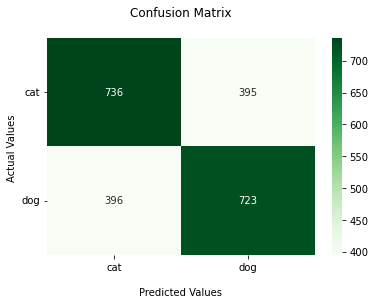

In [22]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_val, y_pred_XGB)
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Greens')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(["cat","dog"])
ax.yaxis.set_ticklabels(["cat","dog"],rotation=0)

plt.show()

In [ ]:
%%time
from xgboost import XGBClassifier

kf= KFold(n_splits=5, random_state=42, shuffle=True)
XGBClassifier = XGBClassifier(objective="binary:logistic", random_state=42,eval_metric='auc')
XGB = cross_val_score(XGBClassifier, X_train,y_train, cv=kf, scoring='accuracy').mean()
print(XGB)

#### AdaBoostClassifier

In [20]:
%%time
from sklearn.ensemble import AdaBoostClassifier

AdB = AdaBoostClassifier()
AdB.fit(X_train, y_train)
y_pred = AdB.predict(X_val)

accuracy = round(metrics.accuracy_score(y_val, y_pred),3)
print("Accuracy:", accuracy)
#print("Classification Report: \n", metrics.classification_report(y_test, y_pred))

Accuracy: 0.601
CPU times: total: 2min 38s
Wall time: 2min 39s


In [21]:
%%time
from sklearn.ensemble import AdaBoostClassifier

kf= KFold(n_splits=3, random_state=42, shuffle=True)
AdaBoost = AdaBoostClassifier()
AdB = cross_val_score(AdaBoost, X_train,y_train, cv=kf, scoring='accuracy').mean()
print(AdB)


0.5839506172839506
CPU times: total: 4min 36s
Wall time: 4min 38s


### GradientBoostingClassifier

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier(verbose=1).fit(X_train, y_train)
y_pred = GBC.predict(X_val)

accuracy = metrics.accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)
#print("Classification Report: \n", metrics.classification_report(y_test, y_pred))    

      Iter       Train Loss   Remaining Time 
         1           1.3795           20.10m
         2           1.3731           19.27m
         3           1.3676           18.87m
         4           1.3624           18.44m
         5           1.3575           20.04m
         6           1.3532           20.49m
         7           1.3484           20.49m
         8           1.3444           20.13m
         9           1.3397           19.81m
        10           1.3365           19.37m
        20           1.3048           16.24m
        30           1.2798           13.71m
        40           1.2608           11.66m
        50           1.2447            9.59m
        60           1.2292            7.65m
        70           1.2160            5.68m
        80           1.2028            3.76m
        90           1.1910            1.87m
       100           1.1777            0.00s
Accuracy: 0.6528888888888889


### Hyperparameter Tuning: 

In [22]:
#Searching for better performance out of the models with RandomizedSearch
from sklearn.model_selection import RandomizedSearchCV

In [25]:
#XGBClassifier
from xgboost import XGBClassifier
parameters = {
        'learning_rate': [ 0.1,0.3,0.03],
        'max_depth': [5,6,10],
        'min_child_weight': [1, 2],
        'subsample': [0.5,0.6,1],
        'colsample_bytree': [0.3,0.5, 0.7],
        'n_estimators' : [100,150,170,200]
         }

random_XGB = RandomizedSearchCV(XGBClassifier(),parameters, verbose=True, 
                          cv=3,random_state=42, return_train_score=True)
random_XGB.fit(X_train,y_train, eval_metric='auc')
y_pred_XGB_random = random_XGB.predict(X_val)
print ("Accuracy Score = ",metrics.accuracy_score(y_val,y_pred_XGB_random))
print (random_XGB.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Accuracy Score =  0.6746666666666666
{'subsample': 1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.03, 'colsample_bytree': 0.7}


In [29]:
random_XGB.best_params_

{'subsample': 1,
 'n_estimators': 200,
 'min_child_weight': 1,
 'max_depth': 10,
 'learning_rate': 0.03,
 'colsample_bytree': 0.7}